# Visualizing embeddings


In [1]:
import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, \
    AutoModelForQuestionAnswering, Trainer, TrainingArguments, HfArgumentParser, pipeline
from helpers import prepare_dataset_nli, prepare_train_dataset_qa, \
    prepare_validation_dataset_qa, QuestionAnsweringTrainer, compute_accuracy
import os
import json

NUM_PREPROCESSING_WORKERS = 2

In [2]:
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt

In [3]:
def get_tensor(word):
    return torch.tensor(tokenizer(word)['input_ids'][1])

In [4]:
def get_embedding(word):
    tensor = get_tensor(word)
    return embeddings(tensor).detach()

In [5]:
def get_embedding_matrix(words):
    res = []
    for word in words:
        res.append(get_embedding(word))
    return torch.stack(res).numpy()

In [8]:
temp_words = ['hot', 'warm', 'cool', 'cold']

In [26]:
intelligence_words = ['intelligent', 'smart', 'clever', 'dumb', 'stupid', 'idiotic']

In [39]:
other_words = ['arbitrary', 'random', 'friendly', 'angry', 'goat', 'australia', 'billion', 'hunger', 'asbestos']

In [40]:
words = temp_words+other_words+intelligence_words

In [77]:
def similarity(wordset):
    print(wordset)
    for i, word1 in enumerate(wordset):
        for word2 in wordset[i+1:]:
            print(f'{word1} vs {word2}')
            print('distance', torch.norm(get_embedding(word1) - get_embedding(word2)))
            print('similarity', torch.dot(get_embedding(word1), get_embedding(word2)))
            print()

# model - antoynm-negation2

In [78]:
# model pipeline (includes tokenization)
mp = pipeline("question-answering", model='experiments/antonym-negation2/model/', )

In [79]:
tokenizer = mp.tokenizer
model = mp.model
embeddings = model.get_input_embeddings()

In [80]:
X = get_embedding_matrix(words)
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

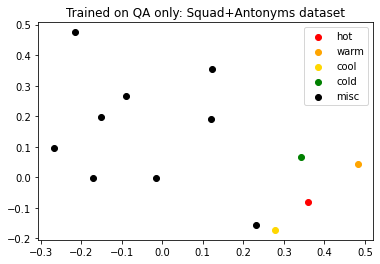

In [81]:
temp_colors = ['red', 'orange', 'gold', 'green']
for i, word in enumerate(temp_words):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=temp_colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc')
plt.title('Trained on QA only: Squad+Antonyms dataset')
plt.legend()

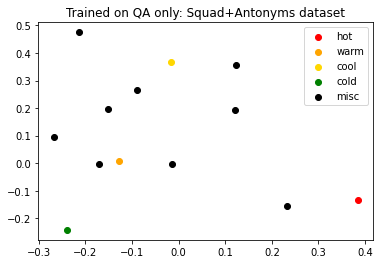

In [89]:
temp_colors = ['red', 'orange', 'gold', 'green']
pca.fit(get_embedding_matrix(temp_words))
for i, word in enumerate(temp_words):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=temp_colors[i], label=word)
plt.scatter(others[:,0], others[:,1], c='k', label='misc')
plt.title('Trained on QA only: Squad+Antonyms dataset')
plt.legend()

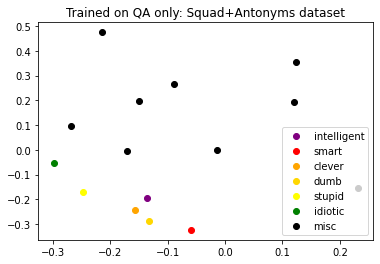

In [82]:
colors = ['purple', 'red', 'orange', 'gold', 'yellow', 'green']
for i, word in enumerate(intelligence_words):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc')
plt.title('Trained on QA only: Squad+Antonyms dataset')
plt.legend()

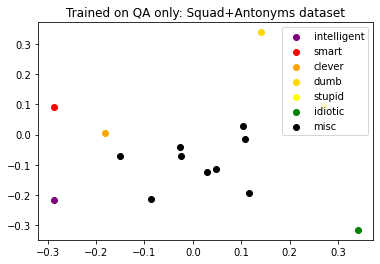

In [90]:
colors = ['purple', 'red', 'orange', 'gold', 'yellow', 'green']
pca.fit(get_embedding_matrix(intelligence_words))
for i, word in enumerate(intelligence_words):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc')
plt.title('Trained on QA only: Squad+Antonyms dataset')
plt.legend()

In [83]:
similarity(temp_words)

['hot', 'warm', 'cool', 'cold']
hot vs warm
distance tensor(0.6426)
similarity tensor(0.1929)

hot vs cool
distance tensor(0.6545)
similarity tensor(0.1771)

hot vs cold
distance tensor(0.6604)
similarity tensor(0.1750)

warm vs cool
distance tensor(0.6178)
similarity tensor(0.1914)

warm vs cold
distance tensor(0.6092)
similarity tensor(0.1984)

cool vs cold
distance tensor(0.6522)
similarity tensor(0.1632)



In [84]:
similarity(intelligence_words)

['intelligent', 'smart', 'clever', 'dumb', 'stupid', 'idiotic']
intelligent vs smart
distance tensor(0.5478)
similarity tensor(0.2167)

intelligent vs clever
distance tensor(0.6123)
similarity tensor(0.1620)

intelligent vs dumb
distance tensor(0.7352)
similarity tensor(0.1193)

intelligent vs stupid
distance tensor(0.7283)
similarity tensor(0.0939)

intelligent vs idiotic
distance tensor(0.7308)
similarity tensor(0.1046)

smart vs clever
distance tensor(0.5534)
similarity tensor(0.2024)

smart vs dumb
distance tensor(0.6243)
similarity tensor(0.2007)

smart vs stupid
distance tensor(0.6895)
similarity tensor(0.1275)

smart vs idiotic
distance tensor(0.7787)
similarity tensor(0.0745)

clever vs dumb
distance tensor(0.6856)
similarity tensor(0.1433)

clever vs stupid
distance tensor(0.6235)
similarity tensor(0.1535)

clever vs idiotic
distance tensor(0.7391)
similarity tensor(0.0873)

dumb vs stupid
distance tensor(0.5281)
similarity tensor(0.2485)

dumb vs idiotic
distance tensor(0.718

# model - trained on mlm antonyms

In [46]:
# model pipeline (includes tokenization)
mp = pipeline("question-answering", model='experiments/mlm_both_plus_qa_both/model/', )

In [47]:
tokenizer = mp.tokenizer
model = mp.model
embeddings = model.get_input_embeddings()

In [91]:
X = get_embedding_matrix(words)
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

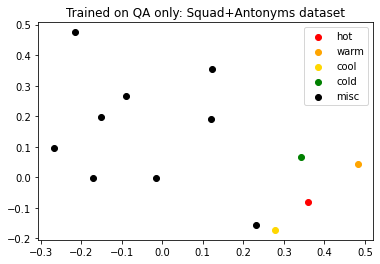

In [92]:
temp_colors = ['red', 'orange', 'gold', 'green']
for i, word in enumerate(temp_words):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=temp_colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc')
plt.title('Trained on QA only: Squad+Antonyms dataset')
plt.legend()

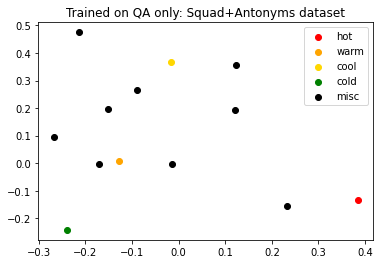

In [93]:
temp_colors = ['red', 'orange', 'gold', 'green']
pca.fit(get_embedding_matrix(temp_words))
for i, word in enumerate(temp_words):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=temp_colors[i], label=word)
plt.scatter(others[:,0], others[:,1], c='k', label='misc')
plt.title('Trained on QA only: Squad+Antonyms dataset')
plt.legend()

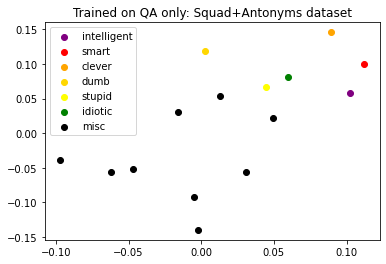

In [94]:
colors = ['purple', 'red', 'orange', 'gold', 'yellow', 'green']
for i, word in enumerate(intelligence_words):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc')
plt.title('Trained on QA only: Squad+Antonyms dataset')
plt.legend()

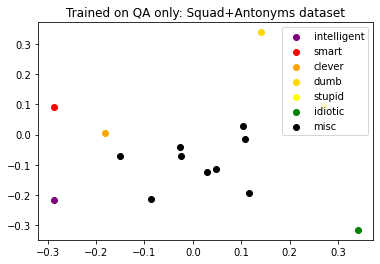

In [95]:
colors = ['purple', 'red', 'orange', 'gold', 'yellow', 'green']
pca.fit(get_embedding_matrix(intelligence_words))
for i, word in enumerate(intelligence_words):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc')
plt.title('Trained on QA only: Squad+Antonyms dataset')
plt.legend()

In [96]:
similarity(temp_words)

['hot', 'warm', 'cool', 'cold']
hot vs warm
distance tensor(0.6426)
similarity tensor(0.1929)

hot vs cool
distance tensor(0.6545)
similarity tensor(0.1771)

hot vs cold
distance tensor(0.6604)
similarity tensor(0.1750)

warm vs cool
distance tensor(0.6178)
similarity tensor(0.1914)

warm vs cold
distance tensor(0.6092)
similarity tensor(0.1984)

cool vs cold
distance tensor(0.6522)
similarity tensor(0.1632)



In [97]:
similarity(intelligence_words)

['intelligent', 'smart', 'clever', 'dumb', 'stupid', 'idiotic']
intelligent vs smart
distance tensor(0.5478)
similarity tensor(0.2167)

intelligent vs clever
distance tensor(0.6123)
similarity tensor(0.1620)

intelligent vs dumb
distance tensor(0.7352)
similarity tensor(0.1193)

intelligent vs stupid
distance tensor(0.7283)
similarity tensor(0.0939)

intelligent vs idiotic
distance tensor(0.7308)
similarity tensor(0.1046)

smart vs clever
distance tensor(0.5534)
similarity tensor(0.2024)

smart vs dumb
distance tensor(0.6243)
similarity tensor(0.2007)

smart vs stupid
distance tensor(0.6895)
similarity tensor(0.1275)

smart vs idiotic
distance tensor(0.7787)
similarity tensor(0.0745)

clever vs dumb
distance tensor(0.6856)
similarity tensor(0.1433)

clever vs stupid
distance tensor(0.6235)
similarity tensor(0.1535)

clever vs idiotic
distance tensor(0.7391)
similarity tensor(0.0873)

dumb vs stupid
distance tensor(0.5281)
similarity tensor(0.2485)

dumb vs idiotic
distance tensor(0.718